# 1. Install & Import Dependencies

In [ ]:
!pip install statsmodels
!pip install pmdarima
!pip install prophet
!pip install tensorflow
!pip install sklearn
!pip install statsmodels

!pip install yfinance

In [2]:
import os
import time
import datetime

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import tensorflow as tf

import yfinance as yf

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs
from pmdarima import auto_arima # SARIMA Model

from prophet import Prophet

%matplotlib inline

# 2. Reading & Process Data

## 2.1. Examin The Data

In [65]:
yahoo_data = yf.Ticker("GOOG")

# df = yahoo_data.history(period='max')
df = yahoo_data.history(start='2020-01-01', end=datetime.datetime.today())
df.index = pd.to_datetime(df.index, format='%Y-%m-%d')

In [66]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-01-02 00:00:00-05:00,67.077499,68.406998,67.077499,68.368500,28132000,0.0,0.0
2020-01-03 00:00:00-05:00,67.392998,68.625000,67.277199,68.032997,23728000,0.0,0.0
2020-01-06 00:00:00-05:00,67.500000,69.824997,67.500000,69.710503,34646000,0.0,0.0
2020-01-07 00:00:00-05:00,69.897003,70.149498,69.518997,69.667000,30054000,0.0,0.0
2020-01-08 00:00:00-05:00,69.603996,70.579002,69.542000,70.216003,30560000,0.0,0.0


In [67]:
df.dtypes

Open            float64
High            float64
Low             float64
Close           float64
Volume            int64
Dividends       float64
Stock Splits    float64
dtype: object

In [68]:
df.index.dtype

datetime64[ns, America/New_York]

In [88]:
df.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Visualize The "Close" Column

<Axes: xlabel='Date'>

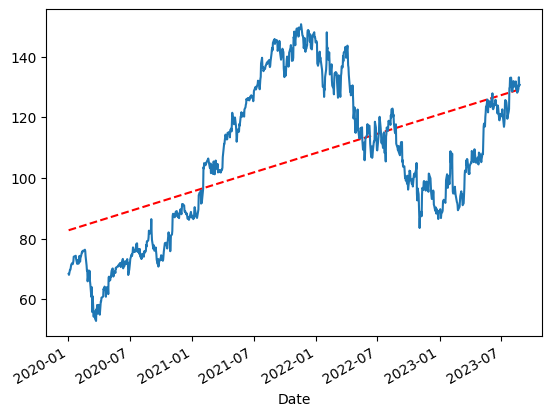

In [256]:
# Plot The Trend Line
trend_line_x = mdates.date2num(df.index)
trend_line_z = np.polyfit(trend_line_x, df['Close'], 1)
trend_line_p = np.poly1d(trend_line_z)
plt.plot(trend_line_x, trend_line_p(trend_line_x), "r--")

# "Close" Plot
df['Close'].plot()

Delete Unused Columns

In [94]:
# del df['Dividends']
# del df['Stock Splits']

In [95]:
# df['Tomorrow'] = df['Close'].shift(-1)

In [96]:
# df.tail()

In [97]:
# df['Target'] = (df['Tomorrow'] > df['Close']).astype('int')
# "1" if the price will go up tomorrow
# "0" if the price will go down tomorrow

In [98]:
# df.head()

## 2.3. Convert daily dataset to weekly dataset

The reason why we are converting to weekly timeframe is that higher the timeframe, lower is the noise and hence increases predictability of the model. One can also convert the data to monthly timeframe and check the predictability of the model.

In [99]:
# df_train_w = df_train.resample('W').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last'})
# df_train_w.head()

In [100]:
# df_test_w = df_test.resample('W').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last'})
# df_test_w.drop(columns=['Open', 'High', 'Low'], inplace=True)

## 2.4. Check for Stationarity

### Conditions
- Mean must be constant
- Variance must be constant
- No seasonality
<img src="https://miro.medium.com/v2/resize:fit:1147/1*xdblkZyg6YmmReAkZHUksw.png" />
An illustration of the principles of stationarity

### Resources
- Stationarity: https://www.youtube.com/watch?v=oY-j2Wof51c


### 2.4.1. ADF Test / Stationary Test [Get `d` parameter]
We will use the Augumented Dickey Fuller (ADF) test to check if the price series is stationary.

The null hypothesis of the ADF test is that the time series is nan-stationary. So, if the p-value of the test is less than the significance level (0.05) then we can reject the null hypothesis and infer that the time series is indeed stationary.

So. in our case, if the p-value > 0.05 we'll need to find the order of differencing.

#### Resources
- Unit Roots: https://www.youtube.com/watch?v=ugOvehrTRRw
- ADF Test: https://www.youtube.com/watch?v=1opjnegd_hA

In [101]:
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC') # .dropna() handles differenced data
    labels = ['ADF test statistic', 'p-value', '# lags used', '# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"

    p_value = result[1]
    if p_value <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [102]:
def is_ds_stationary(ds, columns):
    """
    Check if the DataSet columns are "stationary" using the "ADF Test"
    """

    columns_results = {}

    for column in columns:
      result = adfuller(ds[column].dropna(), autolag='AIC') # .dropna() handles differenced data
      p_value = result[1]
      columns_results[column] = p_value <= 0.05

    return columns_results

In [103]:
# adf_test(df['Price'])
print(is_ds_stationary(df, ['Close', 'Open', 'High', 'Low', 'Volume']))

{'Close': False, 'Open': False, 'High': False, 'Low': False, 'Volume': True}


In [104]:
# The "returns" are more stationary, to use in ARIMA
# The "pct_change" function calculates the percentage change in the values through a series. For example, if the values are [2,3,6] , the returned values would be [NaN, 0.5, 1.0]
df_returns = df['Close'].pct_change().dropna()

In [105]:
adf_test(df_returns)

Augmented Dickey-Fuller Test: 
ADF test statistic     -9.723258e+00
p-value                 9.420156e-17
# lags used             8.000000e+00
# observations          9.090000e+02
critical value (1%)    -3.437564e+00
critical value (5%)    -2.864725e+00
critical value (10%)   -2.568466e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Using a x-order difference of a time series DataFrame is a common technique to transform a non-stationary time series into a stationary one.

Resources
Time series and first differences: https://www.youtube.com/watch?v=nPYPyh20gGo

We can use the `pmdarima` package to get the number of differencing

In [106]:
ndiffs(df_returns, test="adf")

0

$\Rightarrow$ The order of differencing is "0", due to the fact that `df_returns` is `stationary`

### 2.4.2. Partial Auto-Correlation Function (PACF) [Get `p` parameter]
`p` is the order of the Auto Regressive (AR) term. It refers to the number of lags to be used as predictions.

We can find out the required number Of AR terms by inspecting the Partial Autocorrelation (PACF)

The partial autocorrelation represents the correlation between the series and its lags.

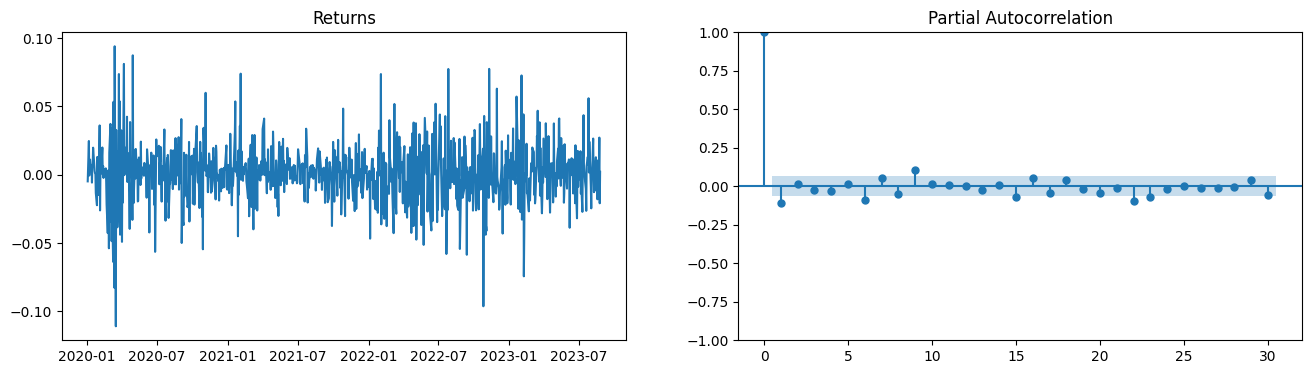

In [107]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(df_returns)
ax1.set_title('Returns')

plot_pacf(df_returns, ax=ax2); # Add ";" at the end of the plot function so that the plot isn't duplicated

$\Rightarrow$ The `p` value is `1`

### 2.4.3. Auto-Correlation Function (ACF) [Get `q` parameter]
`q` is the order of the Moving Average (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA.

We can look at the ACF plot for the number of MA terrns.

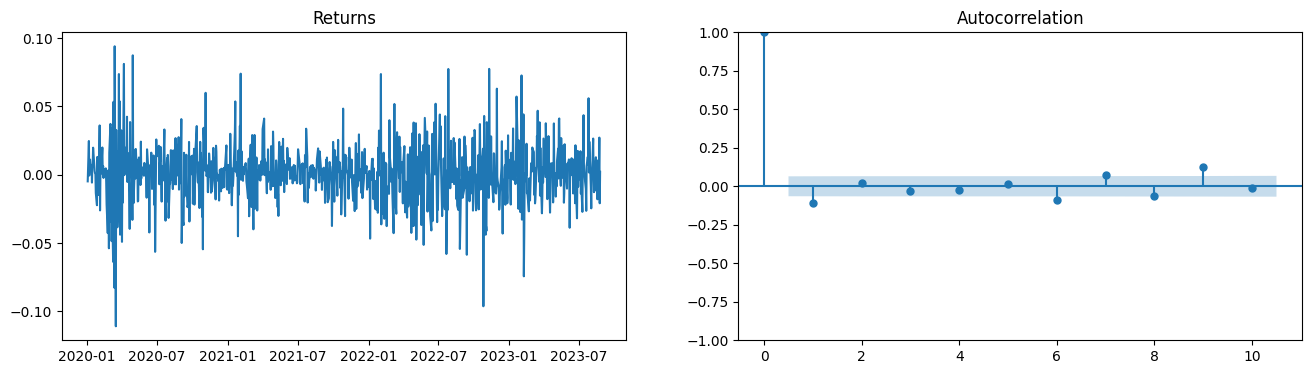

In [108]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(df_returns)
ax1.set_title('Returns')

plot_acf(df_returns, lags=10, ax=ax2); # Add ";" at the end of the plot function so that the plot isn't duplicated

$\Rightarrow$ The `q` value is `1`

## 2.5. Split "Train" & "Test" Sets

In [109]:
test_start_num = int(len(df) * 0.95)

df_train = df[:test_start_num]
df_test = df[test_start_num:]

df_returns_train = df_returns[:test_start_num]
df_returns_test = df_returns[test_start_num:]

# In time series data we can't use cross validation, because if we use it our results will be amazing when we are training and horrible in the real world, and the reason why is if we use cross validation we will be using future data to predict past data, which is impossible in the real world and it will result in something called"leakage" ehere we are leaking information into the model.

# 3. Train Model

## 3.1. Vector Auto Regression (VAR)

### Resources
- https://www.youtube.com/watch?v=5-2C4eO4cPQ
- https://www.youtube.com/watch?v=UQQHSbeIaB0

## 3.2. Autoregressive Integrated Moving Average (ARIMA)

ARIMA models can handle cases where the non-stationarity is due to a unit-root but may not work well at all when non-stationarity is of another form.

### When to use ARIMA?
- Non-Stationary data (else, we use ARMA)
- Univariate data (else, we use VARMA family)
- Need of explainability?

  If we need explainability in modelling we should not use the ARIMA model because its nature is not very explainable. In such situations, we can choose models like exponential smoothing, moving average (MA) etc. the reason behind the less explainability is the combination of three modelling procedures makes it difficult to interpret models with higher values.

- Computational constraints

  With very long time series this model becomes very expensive and slow in computation. The reason for being weak at computation is the moving average and integration part of the model because applying differencing more than once is also a high computational process and the moving average is the linear combination of the errors.  Also sometimes they can perform poorly if we don’t have prior knowledge about choosing the right value of parameters.

- Continuity of the data

  With the ARIMA model, it becomes compulsory to record data points in a regular time interval. If there are missing values in the time series then this model can not be applied to the time series.  The reason behind this problem is we are applying a moving average which moves the window through the time series and finds the trend of the time series. If the trend is broken at a point, it stops working and can cause the models to not perform.

### Parameters
- p: Order of the AR term
- d: Number of differencing required to make the time series stationary
- q: Order of MA term



### Resources
- https://analyticsindiamag.com/5-conditions-when-the-arima-model-should-be-avoided/

In [111]:
from numpy.lib.function_base import disp
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(df_returns_train, order=(1, 0, 1)) # (p, d, q)
arima_result = arima_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [112]:
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  873
Model:                 ARIMA(1, 0, 1)   Log Likelihood                2115.444
Date:                Mon, 28 Aug 2023   AIC                          -4222.889
Time:                        08:22:19   BIC                          -4203.801
Sample:                             0   HQIC                         -4215.586
                                - 873                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.375      0.169      -0.000       0.002
ar.L1         -0.2214      0.214     -1.033      0.302      -0.642       0.199
ma.L1          0.1074      0.221      0.486      0.6

0    0.000001
dtype: float64 0    0.02146
dtype: float64


(array([ 0.18611399,  0.12407599,  1.24075995,  3.28801386, 11.29091552,
        23.88462898, 10.42238356,  2.60559589,  0.55834198,  0.55834198]),
 array([-0.10035586, -0.08189177, -0.06342767, -0.04496358, -0.02649949,
        -0.00803539,  0.0104287 ,  0.02889279,  0.04735689,  0.06582098,
         0.08428507]),
 <BarContainer object of 10 artists>)

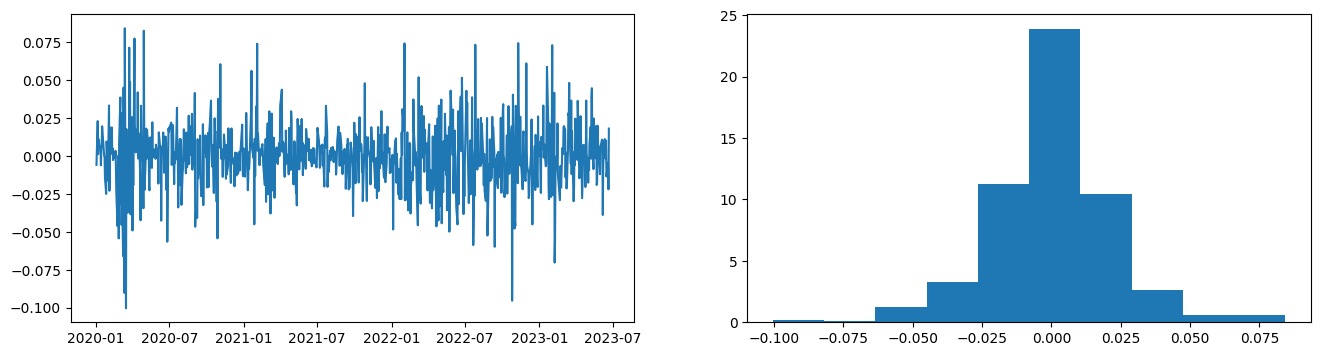

In [113]:
# Plot residual errors
arima_residuals = pd.DataFrame(arima_result.resid)
print(arima_residuals.mean(), arima_residuals.std())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(arima_residuals)
ax2.hist(arima_residuals, density=True)

If the residuals (or errors) of an ARIMA model are close to zero, it suggests that the model is fitting the data well, and the predictions are accurate. Ideally, in a well-fitted ARIMA model, the residuals should be random and have a mean close to zero.

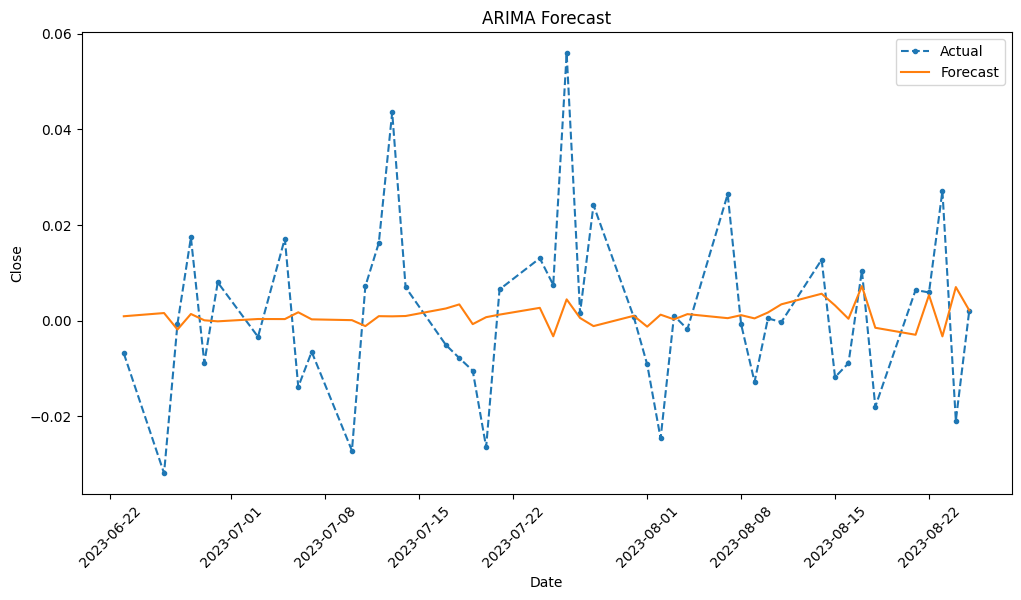

In [120]:
# Actual vs Fitted
arima_predictions = arima_result.predict(0, len(df_returns_test) - 1)
arima_predictions_df = pd.DataFrame({'Close': arima_predictions, 'Date': df_returns_test.index})

plt.figure(figsize=(12, 6))
plt.plot(df_returns_test, label="Actual", marker='.', linestyle='--')
plt.plot('Date', 'Close', data=arima_predictions_df, label="Forecast")
plt.title("ARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Close")
plt.xticks(rotation=45)
plt.legend()

plt.show()

## 3.3. Seasonal Autoregressive Integrated Moving Average (SARIMA)

In [197]:
sarima_model = auto_arima(
    df_returns_train,
    seasonal=False,
    error_ignore='ignore',
    suppress_warnings=True,
    stepwise=True,
    approximation=False,
    m=5
  )

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (5) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


In [198]:
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  873
Model:               SARIMAX(1, 0, 0)   Log Likelihood                2114.397
Date:                Mon, 28 Aug 2023   AIC                          -4224.794
Time:                        09:41:57   BIC                          -4215.250
Sample:                             0   HQIC                         -4221.143
                                - 873                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1138      0.024     -4.696      0.000      -0.161      -0.066
sigma2         0.0005   1.53e-05     30.220      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               225.47
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                            -0.03
Prob(H) (two-sided):                  0.58   Kurtosis:                         5.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [199]:
# Predictions
steps = len(df_returns_test)
sarima_forecast = sarima_model.predict(n_periods=steps, return_conf_int=True, alpha=0.05)
sarima_forecast = pd.DataFrame(sarima_forecast[0], columns=['prediction']).set_index(df_returns_test.index)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


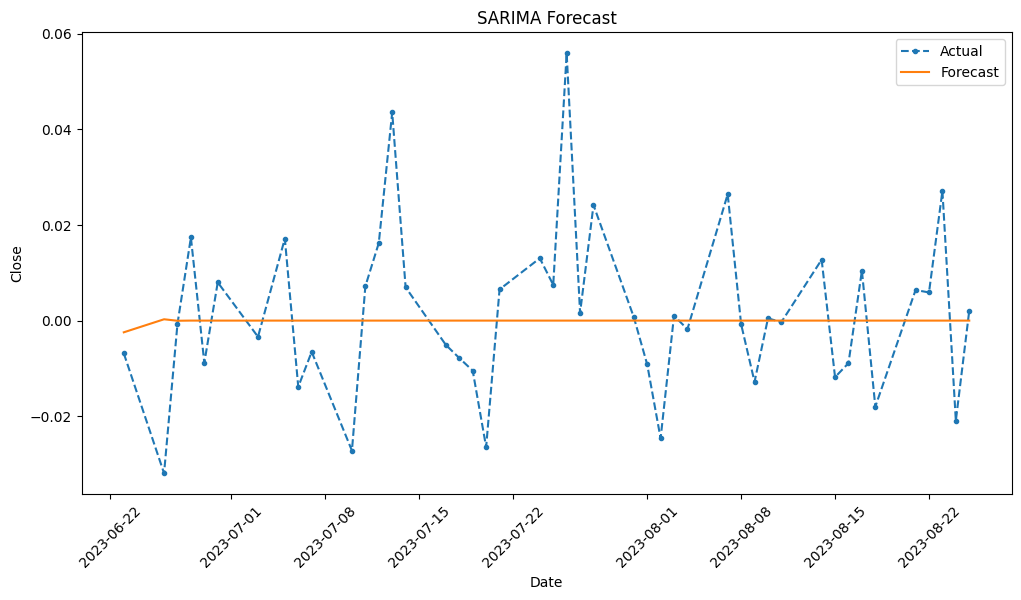

In [200]:
# Actual vs Fitted
plt.figure(figsize=(12, 6))
plt.plot(df_returns_test, label="Actual", marker='.', linestyle='--')
plt.plot(sarima_forecast['prediction'], label="Forecast")
plt.title("SARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Close")
plt.xticks(rotation=45)
plt.legend()

plt.show()

## 3.4. Facebook Prophet

**Accurate and Fast:** It is accurate and generate results very fast

**Reliable:** Facebook Company itself uses Prophet for Internal forecasting

**Fully Automatic:** Works with missing data & No need to perform extensive data Preprocessing

**Domain Knowledge Integration:** Forecasting can be made better by adding domain knowledge expertise like holidays & patterns

**Available in R and Python:** We will be using Python Programming Language

### 3.4.1. Data Preparation

In [151]:
# Train Set
df_prophet_train = pd.DataFrame()
df_prophet_train['y'] = df_returns_train
df_prophet_train['ds'] = pd.to_datetime(df_returns_train.index, format='%Y-%m-%d')
df_prophet_train['ds'] = df_prophet_train['ds'].dt.tz_localize(None)
df_prophet_train = df_prophet_train.reset_index(drop=True)

# Test Set
df_prophet_test = pd.DataFrame()
df_prophet_test['y'] = df_returns_test
df_prophet_test['ds'] = pd.to_datetime(df_returns_test.index, format='%Y-%m-%d')
df_prophet_test['ds'] = df_prophet_test['ds'].dt.tz_localize(None)
df_prophet_test = df_prophet_test.reset_index(drop=True)

In [ ]:
print(df_prophet_train)
print(df_prophet_test)

In [153]:
# prophet_model = Prophet(interval_width=0.95, daily_seasonality=True)
prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(df_prophet_train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmphrpo5zy_/31w11ng7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphrpo5zy_/_770obsx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40929', 'data', 'file=/tmp/tmphrpo5zy_/31w11ng7.json', 'init=/tmp/tmphrpo5zy_/_770obsx.json', 'output', 'file=/tmp/tmphrpo5zy_/prophet_modelnrfl6m8d/prophet_model-20230828090323.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:03:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:03:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [155]:
# prophet_future = prophet_model.make_future_dataframe(periods=30)
# prophet_forecast = prophet_model.predict(prophet_future)

prophet_forecast = prophet_model.predict(df_prophet_test)

In [156]:
prophet_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-06-23,-0.004724,-0.027386,0.030329,-0.004724,-0.004724,0.005094,0.005094,0.005094,0.004792,...,-0.000422,-0.000422,-0.000422,0.000724,0.000724,0.000724,0.0,0.0,0.0,0.000369
1,2023-06-26,-0.004726,-0.027369,0.027527,-0.004726,-0.004726,0.005012,0.005012,0.005012,0.004792,...,-0.001106,-0.001106,-0.001106,0.001326,0.001326,0.001326,0.0,0.0,0.0,0.000285
2,2023-06-27,-0.004727,-0.024513,0.031192,-0.004727,-0.004727,0.006706,0.006706,0.006706,0.004792,...,0.000409,0.000409,0.000409,0.001506,0.001506,0.001506,0.0,0.0,0.0,0.001979
3,2023-06-28,-0.004728,-0.025597,0.030175,-0.004728,-0.004728,0.008003,0.008003,0.008003,0.004792,...,0.001541,0.001541,0.001541,0.001670,0.001670,0.001670,0.0,0.0,0.0,0.003275
4,2023-06-29,-0.004729,-0.024407,0.029629,-0.004729,-0.004729,0.007385,0.007385,0.007385,0.004792,...,0.000775,0.000775,0.000775,0.001818,0.001818,0.001818,0.0,0.0,0.0,0.002657


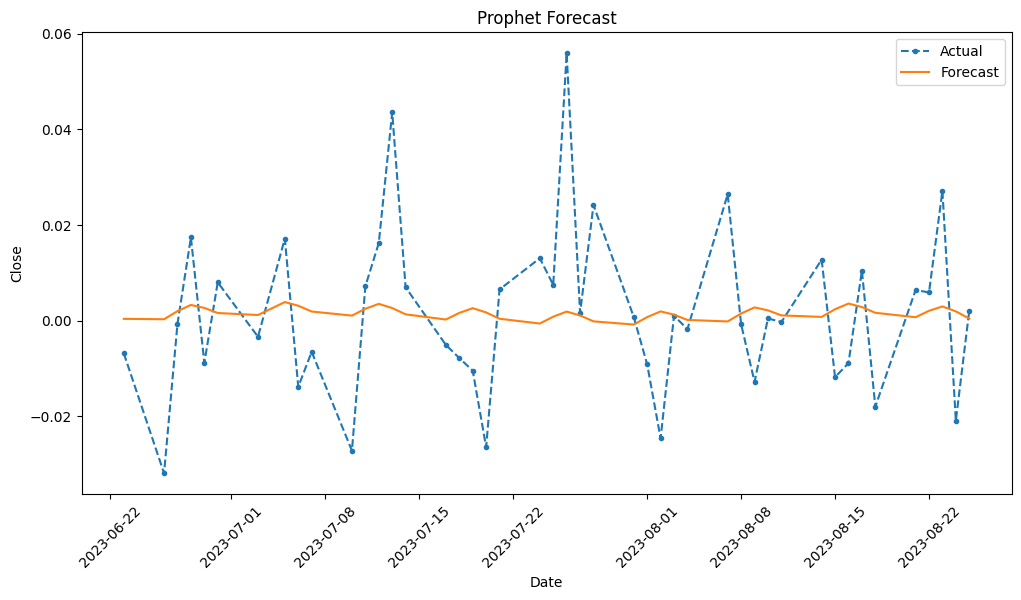

In [160]:
# Actual vs Fitted
plt.figure(figsize=(12, 6))
plt.plot(df_prophet_test['ds'], df_prophet_test['y'], label="Actual", marker='.', linestyle='--')
plt.plot(prophet_forecast['ds'], prophet_forecast['yhat'], label="Forecast")
plt.title("Prophet Forecast")
plt.xlabel("Date")
plt.ylabel("Close")
plt.xticks(rotation=45)
plt.legend()

plt.show()

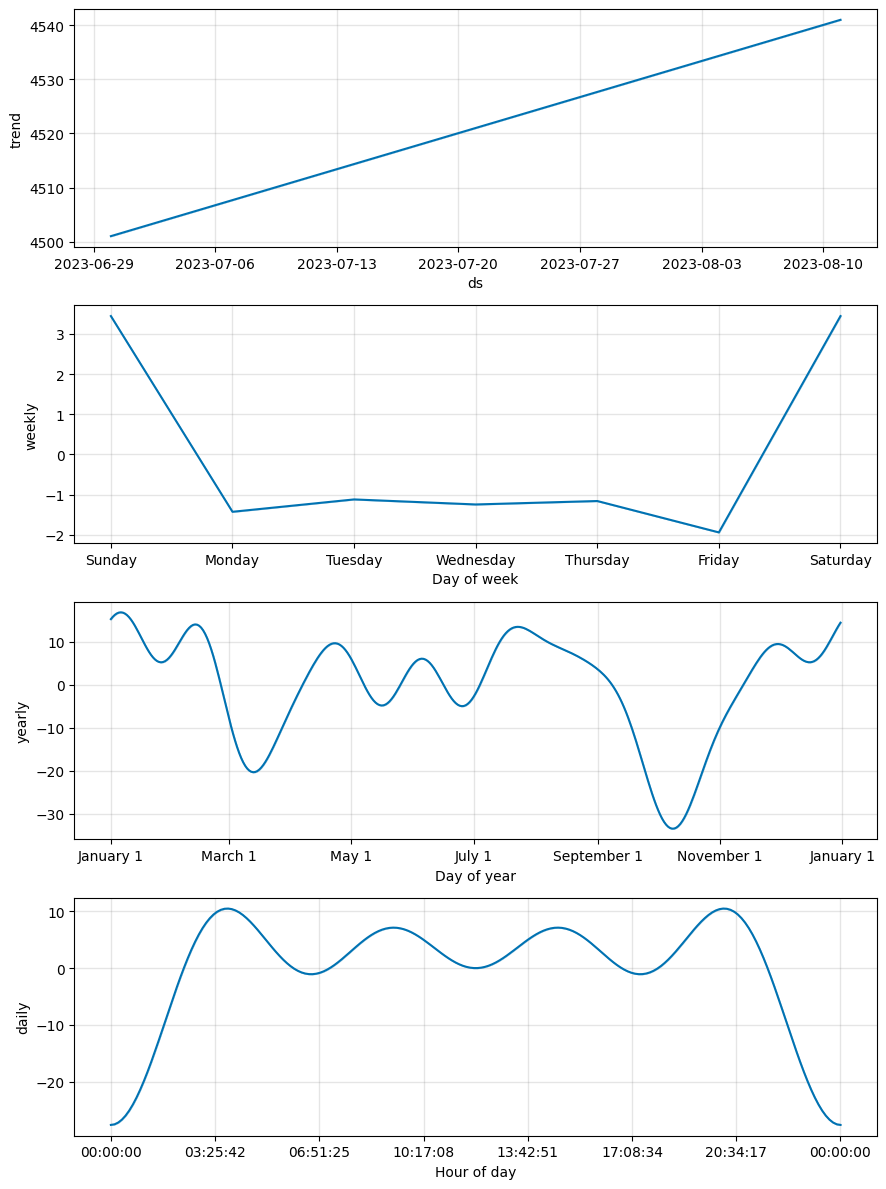

In [ ]:
prophet_model.plot_components(prophet_forecast);

## 3.5. Deep Learning - LSTM

In [162]:
def df_to_X_y(df, window_size=5, horizon=5):
  df_as_np = np.array(df)

  X = []
  y = []

  for i in range(len(df_as_np) - window_size - horizon):
    row = df_as_np[i:i + window_size]
    X.append(row)

    labels = df_as_np[i + window_size:i + window_size + horizon]
    # labels = df_as_np[i:i + window_size]
    y.append(labels)

  return np.array(X), np.array(y)

In [182]:
WINDOW_SIZE = 50
HORIZON = 1
X_train, y_train = df_to_X_y(df_returns_train, WINDOW_SIZE, HORIZON)
X_test, y_test = df_to_X_y(df_returns_test, WINDOW_SIZE, HORIZON)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(822, 50) (822, 1)
(0,) (0,)


In [183]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [184]:
model_1 = Sequential()
model_1.add(InputLayer((WINDOW_SIZE, 1)))
model_1.add(LSTM(64))
model_1.add(Dense(64, 'relu'))
model_1.add(Dense(32, 'relu'))
model_1.add(Dense(HORIZON, 'linear'))

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 23,169
Trainable params: 23,169
Non-trainable params: 0
_________________________________________________________________


In [185]:
model_1.compile(
  loss=MeanSquaredError(),
  optimizer=Adam(learning_rate=0.001),
  metrics=[RootMeanSquaredError()]
)

In [186]:
model_1.fit(
  X_train,
  y_train,
  epochs=100,
)

Epoch 1/100
26/26 [==============================] - 3s 7ms/step - loss: 4.3548e-04 - root_mean_squared_error: 0.0209
Epoch 2/100
26/26 [==============================] - 0s 7ms/step - loss: 4.3477e-04 - root_mean_squared_error: 0.0209
Epoch 3/100
26/26 [==============================] - 0s 10ms/step - loss: 4.3686e-04 - root_mean_squared_error: 0.0209
Epoch 4/100
26/26 [==============================] - 0s 10ms/step - loss: 4.3197e-04 - root_mean_squared_error: 0.0208
Epoch 5/100
26/26 [==============================] - 0s 7ms/step - loss: 4.3918e-04 - root_mean_squared_error: 0.0210
Epoch 6/100
26/26 [==============================] - 0s 7ms/step - loss: 4.2982e-04 - root_mean_squared_error: 0.0207
Epoch 7/100
26/26 [==============================] - 0s 7ms/step - loss: 4.2913e-04 - root_mean_squared_error: 0.0207
Epoch 8/100
26/26 [==============================] - 0s 6ms/step - loss: 4.3293e-04 - root_mean_squared_error: 0.0208
Epoch 9/100
26/26 [==============================] - 0

In [194]:
train_predictions = model_1.predict(X_train)
train_predictions = train_predictions[:,-1]

26/26 [==============================] - 0s 4ms/step


In [195]:
print(train_predictions.shape)

(822,)


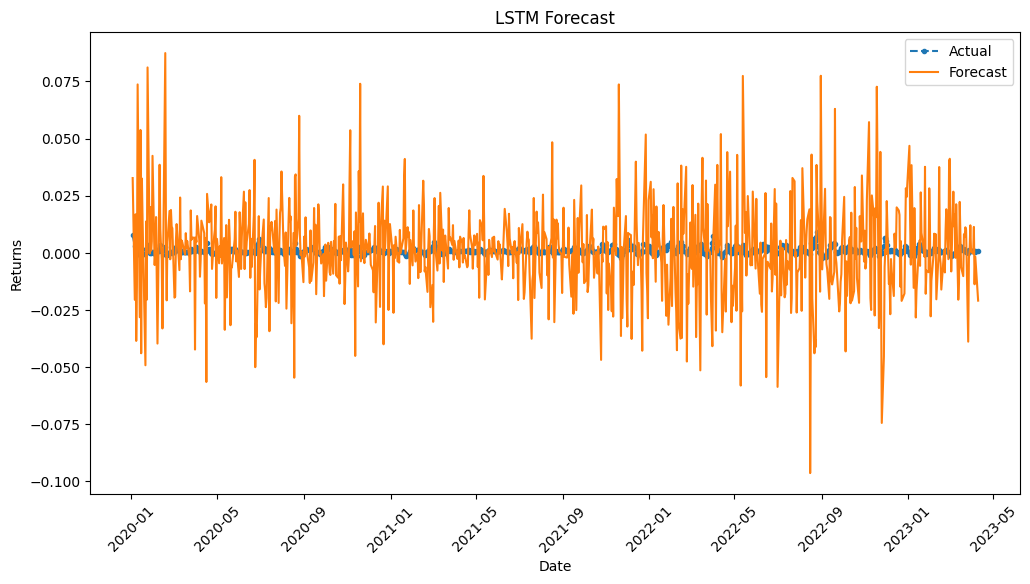

In [196]:
# Actual vs Fitted
plt.figure(figsize=(12, 6))
plt.plot(df_returns_train.index[:len(train_predictions)], train_predictions, label="Actual", marker='.', linestyle='--')
plt.plot(df_returns_train.index[:len(train_predictions)], y_train, label="Forecast")
plt.title("LSTM Forecast")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.xticks(rotation=45)
plt.legend()

plt.show()

In [ ]:
# val_predictions = model_1.predict(X_val).flatten()

# plt.plot(df_val.index[:len(val_predictions)], val_predictions)
# plt.plot(df_val.index[:len(val_predictions)], y_val)

# plt.legend(['Validation Predictions', 'Validation Actual'])

In [ ]:
# test_predictions = model_1.predict(X_test).flatten()

# plt.plot(df_test.index[:len(test_predictions)], test_predictions)
# plt.plot(df_test.index[:len(test_predictions)], y_test)

# plt.legend(['Testing Predictions', 'Testing Actual'])

In [168]:
# from datetime import datetime, timedelta

# def generate_dates(start_date_str, end_date_str):
#   start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
#   # start_date = start_date_str
#   end_date = datetime.strptime(end_date_str, '%Y-%m-%d')
#   # end_date = end_date_str

#   date_list = []
#   current_date = start_date

#   while current_date <= end_date:
#     date_list.append(current_date.strftime('%Y-%m-%d'))
#     current_date += timedelta(days=1)

#   return date_list

In [169]:
# def predict_date(data, data_last_date, date_to_predict, window_size):
#   predictions = []

#   dates = generate_dates(data_last_date, date_to_predict)[1:]

#   X = [data[i] for i in range(window_size)]

#   for date in dates:
#     predicted_value = float(model_1.predict([X]).flatten()[0])
#     predictions.append(predicted_value)

#     # Remove first element
#     X.pop(0)

#     # Add the new prediction, so we can predict the next date
#     X.append(predictions[-1])

#   return dates, np.array(predictions).flatten()

In [212]:
# test_pred = model_1.predict([df_returns_train[:WINDOW_SIZE]]).flatten()

# plt.plot(test_pred)

In [ ]:
# # predicted_dates, predicted_values = predict_date(df['Close'], df.index[-1].strftime('%Y-%m-%d'), '2023-12-20', WINDOW_SIZE)
# # predicted_dates, predicted_values = predict_date(df['Close'], '2023-04-01', '2023-05-01', WINDOW_SIZE)
# # predicted_dates, predicted_values = predict_date(df['Close'], df_val.index[0].strftime('%Y-%m-%d'), df_val.index[-1].strftime('%Y-%m-%d'), WINDOW_SIZE)

# for i in range(10):
#   predicted_dates, predicted_values = predict_date(df_returns_train, df_test.index[i * 10].strftime('%Y-%m-%d'), df_test.index[(i + 1) * 10].strftime('%Y-%m-%d'), WINDOW_SIZE)
#   plt.plot(predicted_dates, predicted_values)

# plt.show()

# df_returns_train.plot()

## 3.6. Random Forest Classifier

- Random Forest works by training a bunch of individual desision trees with randomized parameters and then averaging the results from those decision trees. Because of this, Random Forest is harder to overfit.
- Run quickly.
- It can pick up non-linear tendencies in the data.

In [202]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

In [203]:
rf_model = RandomForestRegressor(
  n_estimators=200,
  min_samples_split=50,
  random_state=1
)
# n_estimators: number of decision trees we want to train
# min_samples_split: this help us to prevent overfitting

In [204]:
rf_predector_columns = ['Volume', 'Open', 'High', 'Low']

In [205]:
rf_column_to_predict = ['Close']

In [206]:
rf_model.fit(df_train[rf_predector_columns], df_train[rf_column_to_predict])

<ipython-input-206-2fac13e1d22c>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(df_train[rf_predector_columns], df_train[rf_column_to_predict])


RandomForestRegressor(min_samples_split=50, n_estimators=200, random_state=1)

In [209]:
from sklearn.metrics import precision_score

# Measure what percentage of the time when we said that the market go up (when the target was a "1"), did it actually go up
rf_predictions = rf_model.predict(df_test[rf_predector_columns])
rf_predictions = pd.Series(rf_predictions, index=df_test.index)

# print(rf_predictions)

In [210]:
# precision_score(df_test[rf_column_to_predict], rf_predictions)

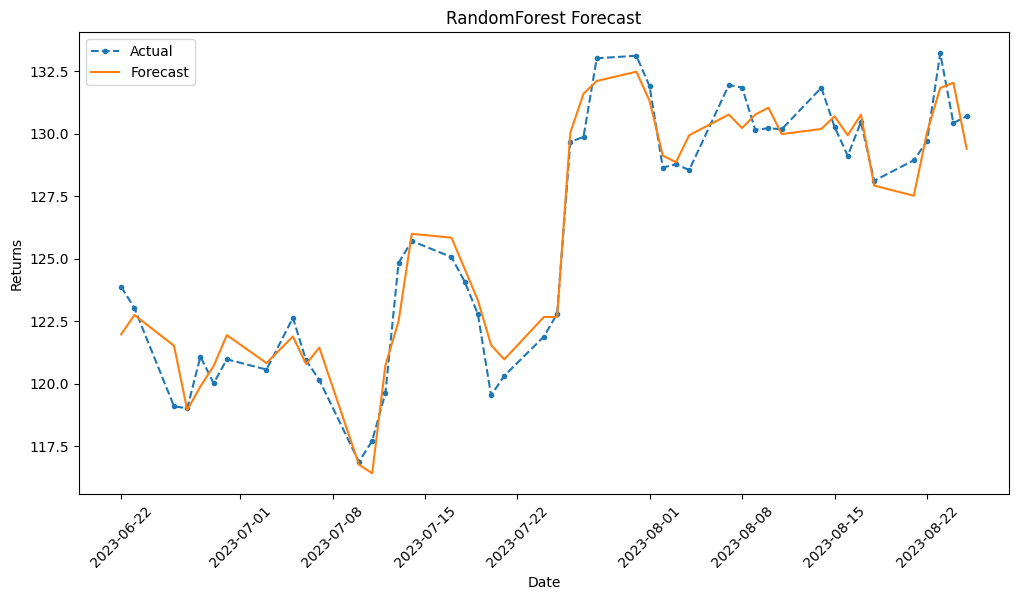

In [214]:
# Actual vs Fitted
plt.figure(figsize=(12, 6))
plt.plot(df_test.index, df_test[rf_column_to_predict], label="Actual", marker='.', linestyle='--')
plt.plot(df_test.index, rf_predictions, label="Forecast")
plt.title("RandomForest Forecast")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.xticks(rotation=45)
plt.legend()

plt.show()

### Backtesting

In [219]:
# def rf_predict(train, test, predictors, model):
#   model.fit(train[predictors], train[rf_column_to_predict])

#   predictions = model.predict(test[predictors])
#   # predictions = model.predict_proba(test[predictors])[:, 1]
#   # predictions[predictions >= 0.6] = 1
#   # predictions[predictions < 0.6] = 0
#   predictions = pd.Series(predictions, index=test.index, name="Predictions")

#   combined = pd.concat([test[rf_column_to_predict], predictions], axis=1)
#   return combined

In [220]:
# def backtest(data, model, predictors, start=2500, step=250):
#   all_predictions = []

#   for i in range(start, data.shape[0], step):
#     train = data.iloc[0:i].copy()
#     test = data.iloc[i:(i + step)].copy()

#     predictions = rf_predict(train, test, predictors, model)
#     all_predictions.append(predictions)

#   return pd.concat(all_predictions)

In [221]:
# backtest_predictions = backtest(df, rf_model, rf_predector_columns, start=0)

In [222]:
# backtest_predictions['Predictions'].value_counts()

In [223]:
# precision_score(backtest_predictions['Target'], backtest_predictions['Predictions'])

In [ ]:
# backtest_predictions['Target'].value_counts() / backtest_predictions.shape[0]

In [224]:
# combined = pd.concat([df_test[rf_column_to_predict], backtest_predictions], axis=1)
# combined.plot()

In [ ]:
# horizons = [2, 5, 60, 250, 1000]

# new_predictors = []

# for horizon in horizons:
#   rolling_averages = df.rolling(horizon).mean()

#   ratio_column = f"Close_Ratio_{horizon}"
#   df[ratio_column] = df['Close'] / rolling_averages['Close']

#   trend_column = f"Trend_{horizon}"
#   df[trend_column] = df.shift(1).rolling(horizon).sum()['Target']

#   new_predictors += [ratio_column, trend_column]

In [ ]:
# df.head()

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0,0.998706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0,0.995675,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1,0.995098,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0,1.002252,1.0,0.993731,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [225]:
# df = df.dropna()

In [226]:
# df.head()

In [227]:
# backtest_predictions = backtest(df, rf_model, new_predictors)

In [ ]:
# backtest_predictions["Predictions"].value_counts()

In [ ]:
# precision_score(backtest_predictions[rf_column_to_predict], backtest_predictions['Predictions'])

In [228]:
# combined = pd.concat([df_test[rf_column_to_predict], backtest_predictions], axis=1)
# combined.plot()

## 3.7. Simple Exponential Smoothing (SES)

In [230]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [249]:
forecast_steps = len(df_test)

ses_model = SimpleExpSmoothing(df_train['Close'])
ses_model_fitted = ses_model.fit()
ses_predictions = ses_model_fitted.predict(start=1, end=forecast_steps)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


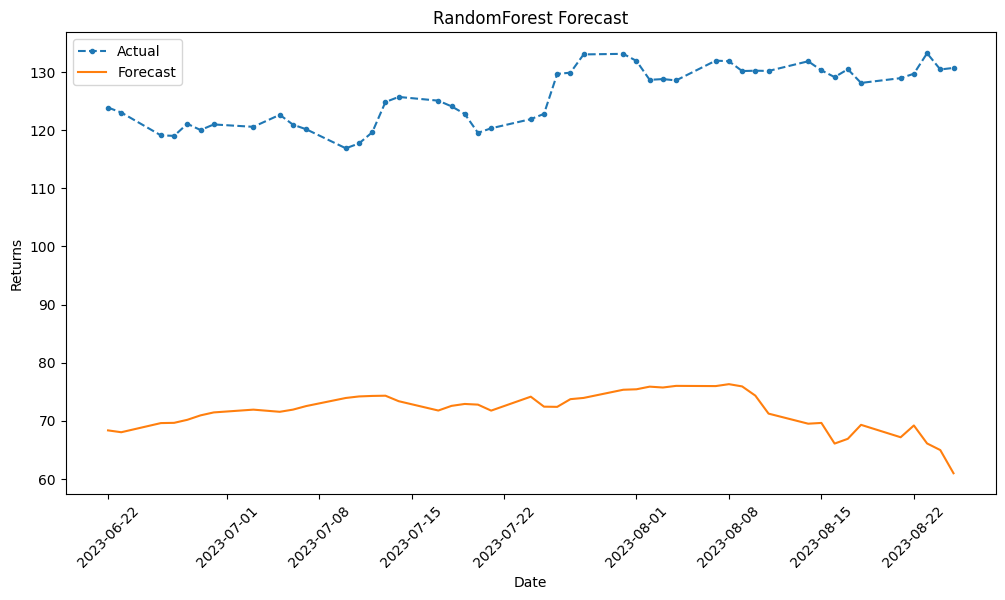

In [250]:
# Actual vs Fitted
plt.figure(figsize=(12, 6))
plt.plot(df_test['Close'].index, df_test['Close'], label="Actual", marker='.', linestyle='--')
plt.plot(df_test['Close'].index, ses_predictions, label="Forecast")
plt.title("RandomForest Forecast")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.xticks(rotation=45)
plt.legend()

plt.show()

# 4. Conclusion

## ARIMA
This model doesn't give accurate value, but gives approximatly right direction of the stocks (up or down)

## SARIMA
This model dosn't give any good results unfortunately

## Prophet
This model doesn't give accurate value, but gives approximatly right direction of the stocks (up or down)

## LSTM
This model didn't give good results

## RandomForest
This model give really good predicted values and right directions of the stocks, but for shror period of time (Tested on one day in the future)

## Simple Exponential Smoothing
This model didn't give good results, neither for predicted values of directions